### Libs imports

In [1]:
# Execute extenttion to reload files in project dir
%load_ext autoreload
%autoreload 2

In [2]:

# Add link to project root
import sys, os
sys.path.append(os.path.abspath('..'))

In [3]:
import pandas as pd
import numpy as np
import requests
from tqdm.notebook import tqdm
from joblib import dump, load
import os
import matplotlib.pyplot as plt

from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from source.features.super_trend import calculate_supertrend
from source.features.macd import calculate_macd
from source.features.rsi import calculate_rsi
from source.features.obv import calculate_obv_to_volume_ratio
from source.features.bollinger_bands import distance_between_bb_bands
from source.features.chaikin_money_flow import calculate_cmf
from source.features.rate_of_change import calculate_price_rate_of_change, calculate_volume_rate_of_change
from source.features.volume_ratio import calculate_volume_ratio
from source.features.stoch_rsi import calculate_stoch_rsi
from source.features.linear_regression import calculate_trailing_linear_reg_params
from source.prices_source.binance_prices import get_candles_spot_binance

from source.utils import optimal_threshold

from config import MODELS_PATH, PRICES_PATH

### Data

#### Get Binance data

In [25]:
# Download binance prices
exchange_info = requests.get("https://api.binance.com/api/v3/exchangeInfo").json()
all_symbols = pd.DataFrame(exchange_info['symbols'])

symbols_with_usdt = all_symbols[all_symbols['symbol'].str.contains("USDT")]['symbol'].unique()

# Donwload prices form binance
from tqdm import tqdm_notebook as tqdm
from time import sleep

results = pd.DataFrame({}, columns=["Time", "Open", "High", "Low", "Close", "Volume", "Symbol"]).set_index("Time")

for i, symbol in tqdm(enumerate(symbols_with_usdt)):
    
    try:
        df = get_candles_spot_binance(symbol, "1d", "2018-01-01T10:00:00")
        df.loc[:, "Symbol"] = symbol
        results = pd.concat([results, df])
    except ConnectionError:
        sleep(10)
        df = get_candles_spot_binance(symbol, "1d", "2018-01-01T10:00:00")
        df.loc[:, "Symbol"] = symbol
        results = pd.concat([results, df])
    
results.to_csv(os.path.join(PRICES_PATH, "binance_data.csv"), sep=",")

0it [00:00, ?it/s]

#### Get Moex data

In [5]:
from source.prices_source.moex_prices import get_candles_moex, get_moex_securities

# Download prices from moex
moex_securities = get_moex_securities(engine="stock", market="shares", boards=["TQBR"])

moex_results = pd.DataFrame({}, columns=["Time", "Open", "High", "Low", "Close", "Volume", "Symbol"]).set_index("Time")

for i, ticker in tqdm(enumerate(moex_securities["SECID"])):
    
    try:
        df = get_candles_moex(ticker, 24, "2018-01-01T10:00:00", board="TQBR")
        df.loc[:, "Symbol"] = ticker
        moex_results = pd.concat([moex_results, df])
    except requests.exceptions.ConnectionError as e:
        print(ticker, e)
        continue
    
moex_results.to_csv(os.path.join(PRICES_PATH, "moex_data.csv"), sep=",") 

0it [00:00, ?it/s]

USBN Timeout


#### Data preparation

In [29]:
# Get binance data
results = pd.read_csv(os.path.join(PRICES_PATH, "binance_data.csv"), index_col=0, sep=",")
results.index = results.index.map(lambda x: pd.Timestamp(x, tz="Europe/Moscow"))

In [30]:
# Get Moex
# results = pd.read_csv(os.path.join(PRICES_PATH, "moex_data.csv"), index_col=0, sep=",")
# results.index = results.index.map(lambda x: pd.Timestamp(x, tz="Europe/Moscow"))

In [34]:
from source.utils import normalize_prices


# Features
##############
features = {
    "calculate_supertrend": [["SuperTrend"], {"vol_func": "atr", "lookback": 20, "multiplier": 2.5}],
    "calculate_macd": [["MACD_Signal_Line", "MACD", "MACD_Bar_Charts"], {"short_period": 12, "long_period": 26, "smoothing_period": 9}],
    "calculate_rsi": [["RSI"], {"period": 20, "ema": True}],
    "calculate_obv_to_volume_ratio": [["OBV_Volume_Ratio"], {}],
    "distance_between_bb_bands": [["Upper_distance", "Lower_distance"], {"period": 20, "multiplier": 2.5, "ema": 2.5, "normalize": True}],
    "calculate_cmf": [["CMF"], {"period": 20}],
    "calculate_price_rate_of_change": [["Price_ROC"], {}],
    "calculate_volume_rate_of_change": [["Volume_ROC"], {}],
    "calculate_volume_ratio": [["Volume_Ratio"], {"period": 20, "ema": True}],
    "calculate_stoch_rsi": [["Stoch_RSI_K", "Stoch_RSI_D"], {"rsi_period": 20, "k_period": 20, "smooth_k": 5, "smooth_k": 5, "ema": True}],
    "calculate_trailing_linear_reg_params": [["Reg_Coef", "RMSE"], {"period": 25, "col_name": "cum_prod"}]
}

feature_cols = sum(list(map(lambda x: x[0], features.values())), [])
###############

# Strategy params 
##################
strategy_params = {
    "last_features_window": 7,
    "candles_between_pump": 30,
    "validation_window": 10, # candles
    "min_yield": -20, # %
    "max_yield": 20,
    "first_yield": 3
}
##################

data_set = pd.DataFrame({})

symbols = results["Symbol"].unique()

for symbol in tqdm(symbols):
    
    # Get sample of prices by ticker
    sample = results[results["Symbol"] == symbol]
    
    # Nomalize prices with beggining 100
    # Drop first element to avoid mistakes
    sample.loc[:, ["High", "Low", "Close", "Open"]] = sample.loc[:, ["High", "Low", "Close", "Open"]].apply(normalize_prices)
    sample = sample.iloc[1:]
    
    # Skip if len of prices < time between pump
    if len(sample) < strategy_params["candles_between_pump"]:
        continue

    # Calculate trailing cumulative yield over specified rolling window
    # Calculate yield at 1 day before cumulative yield. In other words yield_before_pump is not included in calculation of cum_prod, yield_before_pump == before pump date
    sample.loc[:, "cum_prod"] = sample["Close"].pct_change().add(1).rolling(window=strategy_params["validation_window"]).apply(np.prod).subtract(1).multiply(100).fillna(0).values
    sample.loc[:, "yield_before_pump"] = sample["Close"].pct_change().multiply(100).shift(strategy_params["validation_window"])
    

    # Calculate features. Feature functions update original DataFrame
    for feature, values in features.items():
        eval(feature)(sample, **values[1])
    
    feature_df = sample[feature_cols].bfill()
    
    # Define pumps
    outliers_values = sample[(sample["cum_prod"] >= strategy_params["max_yield"]) & (sample["yield_before_pump"] >= strategy_params["first_yield"])]
    
    # For diluting data for 0 class in model
    other_values_first = sample[(sample["cum_prod"] < strategy_params["max_yield"]) & (sample["cum_prod"] > 0) & (sample["yield_before_pump"] >= strategy_params["first_yield"])]
    other_values_second = sample[(sample["cum_prod"] < 0) & (sample["yield_before_pump"] >= strategy_params["first_yield"])]
    other_values_third = sample[(sample["yield_before_pump"] < strategy_params["first_yield"])]

    if outliers_values.empty:
        continue
    
    # Filter pumps by appropriate num of candles between pumps
    last_dt = sample.index[0]
    for dt in outliers_values.index:
        outliers_values.loc[dt, "candles_delta"] = len(sample.loc[last_dt:dt])
        last_dt = dt
        
    outliers_values = outliers_values[outliers_values["candles_delta"] >= strategy_params["candles_between_pump"]]

    ### Update dataset for model
    # Fulfill pupmps as 1 class
    for pump_index in outliers_values.index:
        
        before_pump_date = sample.iloc[sample.index.get_loc(pump_index) - (strategy_params["validation_window"])].name # 1 Day before pump
        
        summary_dct = {
            'symbol': symbol,
            'before_pump_date': before_pump_date,
            'data_type': ">5>15",
            'class': 1
        }
        
        # get only last feature values before pump
        last_features = feature_df.loc[:before_pump_date].iloc[-strategy_params["last_features_window"]:]

        for name, values in last_features.items():
            for i, value in enumerate(values):
                summary_dct[name + "_" + str(i)] = value

        summary = pd.DataFrame(summary_dct, index=[len(data_set) + 1])

        data_set = pd.concat([data_set, summary])
         
    # Fulfill samples as 0 class 
    for sample_numb, data_name, other_values in [[4, ">5>0<15", other_values_first], [2, ">5<0", other_values_second], [2, "<0", other_values_third]]:
        
        for date in other_values.sample(frac=1).head(sample_numb).index:
            
            before_pump_date = sample.iloc[sample.index.get_loc(date) - (strategy_params["validation_window"])].name # 1 Day before pump

            summary_dct = {
                'symbol': symbol,
                'before_pump_date': before_pump_date,
                'data_type': data_name,
                'class': 0
            }

            last_features = feature_df.loc[:before_pump_date].iloc[-strategy_params["last_features_window"]:]

            for name, values in last_features.items():
                for i, value in enumerate(values):
                    summary_dct[name + "_" + str(i)] = value

            summary = pd.DataFrame(summary_dct, index=[len(data_set) + 1])

            data_set = pd.concat([data_set, summary])
    print(f'Symbol: {symbol} ', f'Pump number: {outliers_values.shape[0]}')

  0%|          | 0/493 [00:00<?, ?it/s]

Symbol: BTCUSDT  Pump number: 11
Symbol: ETHUSDT  Pump number: 18
Symbol: BNBUSDT  Pump number: 16
Symbol: BCCUSDT  Pump number: 3
Symbol: NEOUSDT  Pump number: 20
Symbol: LTCUSDT  Pump number: 16
Symbol: QTUMUSDT  Pump number: 21
Symbol: ADAUSDT  Pump number: 17
Symbol: XRPUSDT  Pump number: 12
Symbol: EOSUSDT  Pump number: 14
Symbol: IOTAUSDT  Pump number: 15
Symbol: XLMUSDT  Pump number: 15
Symbol: ONTUSDT  Pump number: 16
Symbol: TRXUSDT  Pump number: 10
Symbol: ETCUSDT  Pump number: 13
Symbol: ICXUSDT  Pump number: 17
Symbol: NULSUSDT  Pump number: 16
Symbol: VETUSDT  Pump number: 18
Symbol: BCHABCUSDT  Pump number: 4
Symbol: BCHSVUSDT  Pump number: 0
Symbol: LINKUSDT  Pump number: 15
Symbol: WAVESUSDT  Pump number: 14
Symbol: BTTUSDT  Pump number: 7
Symbol: ONGUSDT  Pump number: 17
Symbol: HOTUSDT  Pump number: 14
Symbol: ZILUSDT  Pump number: 14
Symbol: ZRXUSDT  Pump number: 17
Symbol: FETUSDT  Pump number: 15
Symbol: BATUSDT  Pump number: 13
Symbol: XMRUSDT  Pump number: 9
Symb

In [43]:
print('Dataset stucture:')
data_set.groupby(['class', 'data_type']).symbol.nunique()

Dataset stucture:


class  data_type
0      <0           438
       >5<0         438
       >5>0<15      437
1      >5>15        429
Name: symbol, dtype: int64

In [40]:
data_set['data_type'].value_counts()

data_type
>5>15      3086
>5>0<15    1737
>5<0        876
<0          876
Name: count, dtype: int64

### Modeling 

#### Eval model

In [59]:
import xgboost as xgb

data_set = data_set.dropna()
data_set = data_set[np.all(data_set != np.inf, axis=1)]
feature_names = data_set.drop(["symbol", "before_pump_date", "class", "data_type"], axis=1).columns

X_train, X_test, y_train, y_test = train_test_split(data_set.loc[:, feature_names], data_set.loc[:, 'class'].astype('int'), 
                                                    test_size = 0.2, shuffle=True, random_state=43)

# xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42) # squarederror

# params = {
#     "colsample_bytree": [0.7, 0.3],
#     "gamma": [0, 0.5],
#     "learning_rate": [0.1, 0.03, 0.3], # default 0.1 
#     "max_depth": [2, 6], # default 3
#     "n_estimators": [100, 300], # default 100
#     "subsample": [0.6, 0.4]
# }

# kfold = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

# model = GridSearchCV(xgb_model, 
#                      param_grid=params,
#                      cv=kfold,
#                      verbose=1,
#                      n_jobs=6)


# model.fit(X_train, y_train)

model = load(os.path.join(MODELS_PATH, "xgb_model.joblib"))

# # Common way
# predict = model.best_estimator_.predict(X_test)

#Proba
predict_proba = model.best_estimator_.predict_proba(X_test)
rate, _ = optimal_threshold(predict_proba[:, 1])
predict = predict_proba[:, 1] >= rate * 1
print(rate)


print(classification_report(y_test, predict))
print("accuracy: ", accuracy_score(y_test, predict))
print(confusion_matrix(y_test, predict))

# dump(model, os.path.join(MODELS_PATH, "xgb_model.joblib"))

0.39837214
              precision    recall  f1-score   support

           0       0.92      0.63      0.75       699
           1       0.69      0.94      0.79       607

    accuracy                           0.77      1306
   macro avg       0.80      0.78      0.77      1306
weighted avg       0.81      0.77      0.77      1306

accuracy:  0.7741194486983155
[[443 256]
 [ 39 568]]


#### Boosting k-folds Gradient Boosting

In [67]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold

data_set = data_set.dropna()
data_set = data_set[np.all(data_set != np.inf, axis=1)]
feature_names = data_set.drop(["symbol", "before_pump_date", "class", "data_type"], axis=1).columns
    
kf = KFold(n_splits=2, shuffle=True)
for train, test in kf.split(data_set):
    
    print(len(train), len(test))
    
    X_train, y_train = data_set.iloc[train].loc[:, feature_names], data_set.iloc[train]['class'].astype('int')
    X_test, y_test = data_set.iloc[test].loc[:, feature_names], data_set.iloc[test]['class'].astype('int')
    print(y_train.value_counts(), "\n", y_test.value_counts())
    
    rf_params = {
            'loss' : ['exponential'],
            # 'n_estimators' : [100, 200, 300],
            'learning_rate': [0.1, 0.05, 0.01],
        #     'max_depth': [4, 8],
        #     'min_samples_leaf': [100, 150],
        #     'max_features': [0.3, 0.1]
    }

    kfold = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

    gb_model = GridSearchCV(GradientBoostingClassifier(),
                        param_grid=rf_params,
                        cv=kfold,
                        n_jobs=6,
                        scoring="roc_auc",
                        verbose=2,
                        )

    gb_model.fit(X_train, y_train)


    predict = gb_model.best_estimator_.predict(X_test)
    # predict_proba = random_forest_model.best_estimator_.predict_proba(X_test)

    # rate, _ = optimal_threshold(predict_proba[:, 1])

    # print(rate)
    print(classification_report(y_test, predict))
    print("accuracy: ", accuracy_score(y_test, predict))
    print(confusion_matrix(y_test, predict))
    print("\n\n\n")

3265 3265
class
0    1713
1    1552
Name: count, dtype: int64 
 class
0    1731
1    1534
Name: count, dtype: int64
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ................learning_rate=0.1, loss=exponential; total time=  15.8s
[CV] END ...............learning_rate=0.05, loss=exponential; total time=  15.8s
[CV] END ................learning_rate=0.1, loss=exponential; total time=  16.0s
[CV] END ................learning_rate=0.1, loss=exponential; total time=  16.0s
[CV] END ................learning_rate=0.1, loss=exponential; total time=  16.2s
[CV] END ................learning_rate=0.1, loss=exponential; total time=  16.4s
[CV] END ...............learning_rate=0.01, loss=exponential; total time=  14.0s
[CV] END ...............learning_rate=0.01, loss=exponential; total time=  14.1s
[CV] END ...............learning_rate=0.05, loss=exponential; total time=  14.7s
[CV] END ...............learning_rate=0.05, loss=exponential; total time=  14.9s
[CV] END .....

#### Train XgBoost model

In [48]:
data_set = data_set.dropna()
data_set = data_set[np.all(data_set != np.inf, axis=1)]
feature_names = data_set.drop(["symbol", "pump_date", "class", "data_type"], axis=1).columns

X_train, X_test, y_train, y_test = train_test_split(data_set.loc[:, feature_names], data_set.loc[:, 'class'].astype('int'), 
                                                    test_size = 0.2, shuffle=True)

import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42) # squarederror

params = {
    "colsample_bytree": [0.7, 0.3],
    "gamma": [0, 0.5],
    "learning_rate": [0.1, 0.03, 0.3], # default 0.1 
    "max_depth": [2, 6], # default 3
    "n_estimators": [100, 300], # default 100
    "subsample": [0.6, 0.4]
}

kfold = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

model = GridSearchCV(xgb_model, 
                     param_grid=params,
                     cv=kfold,
                     verbose=1,
                     n_jobs=6)


model.fit(X_train, y_train)


predict = model.best_estimator_.predict(X_test)
# predict_proba = random_forest_model.best_estimator_.predict_proba(X_test)

# rate, _ = optimal_threshold(predict_proba[:, 1])

# print(rate)
print(classification_report(y_test, predict))
print("accuracy: ", accuracy_score(y_test, predict))
print(confusion_matrix(y_test, predict))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
              precision    recall  f1-score   support

           0       0.75      0.67      0.71       651
           1       0.59      0.68      0.63       453

    accuracy                           0.68      1104
   macro avg       0.67      0.68      0.67      1104
weighted avg       0.69      0.68      0.68      1104

accuracy:  0.6757246376811594
[[438 213]
 [145 308]]


#### Feature importance

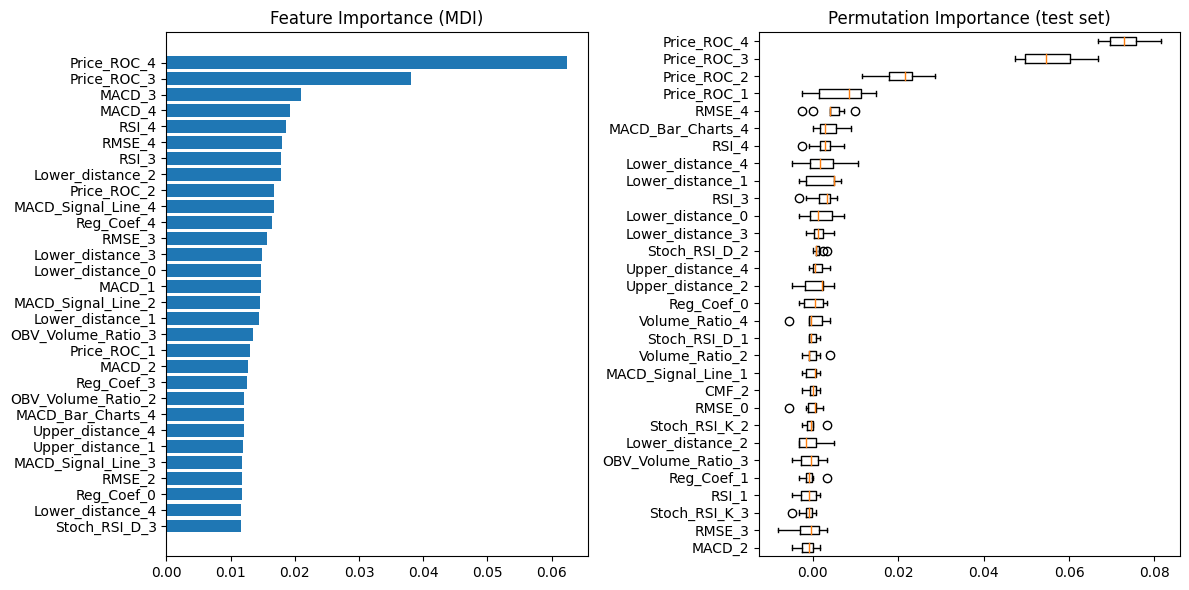

In [43]:
from sklearn.inspection import permutation_importance

feature_names = data_set.drop(["symbol", "pump_date", "class", "data_type"], axis=1).columns.values

feature_importance = model.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance)[-30:]
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, feature_names[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    model.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()[-30:]
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=feature_names[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Изменение кэфа

#### Plots

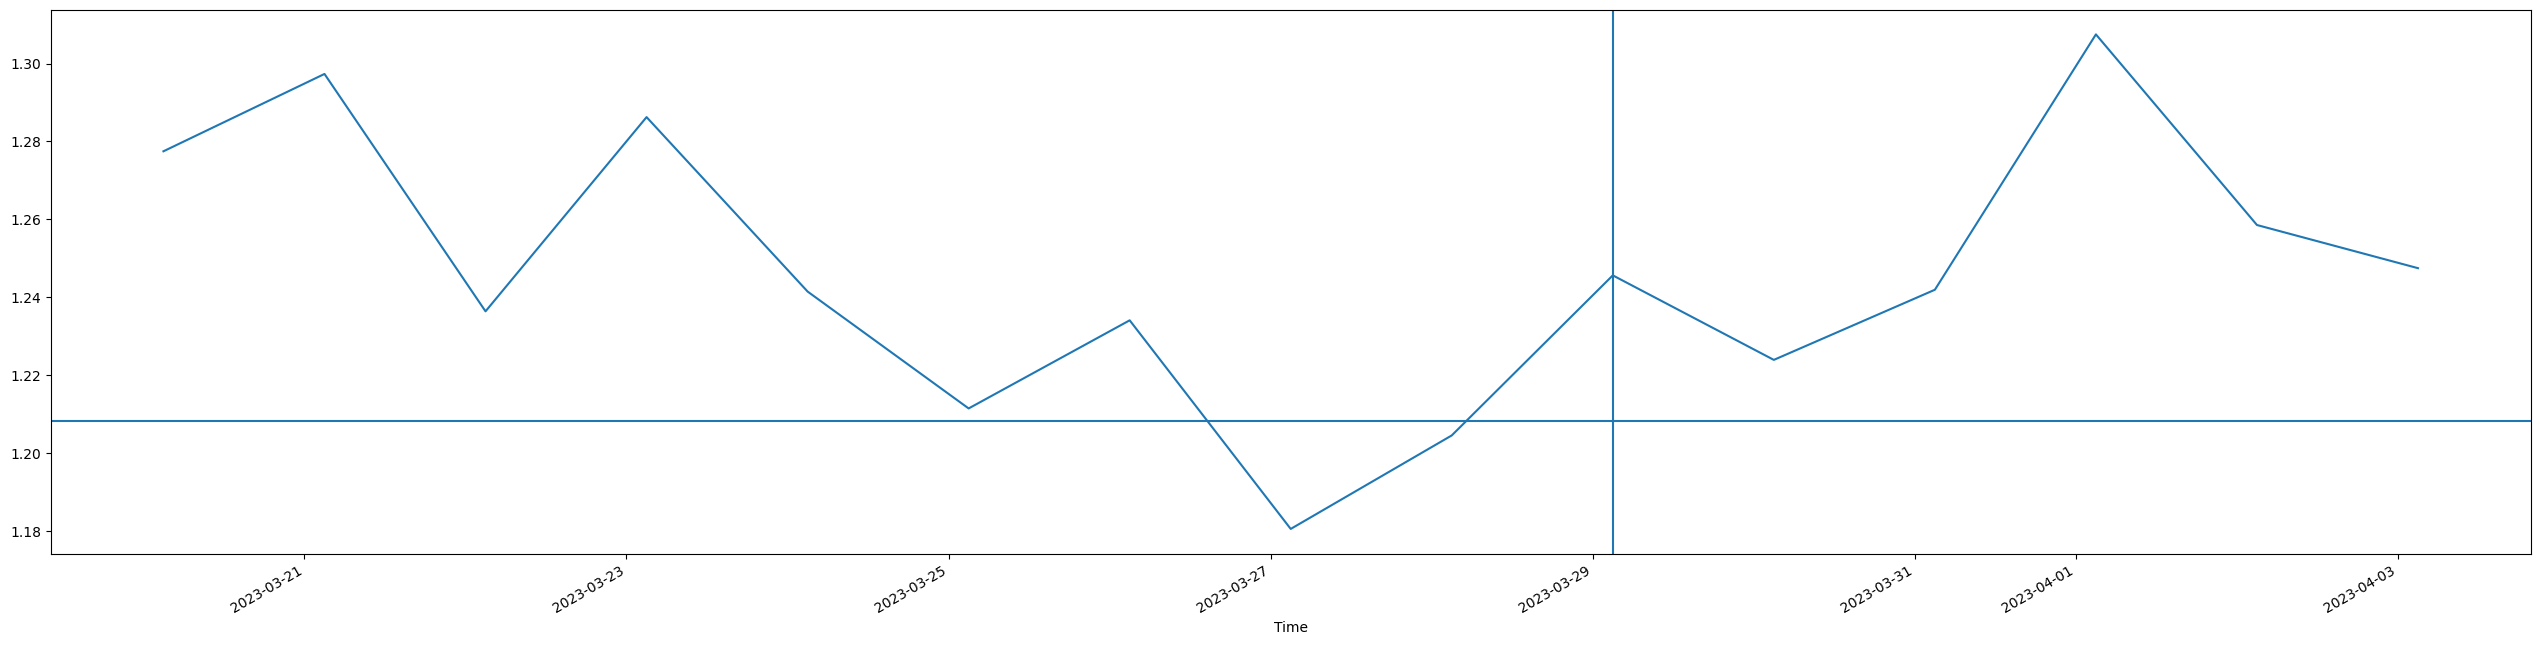

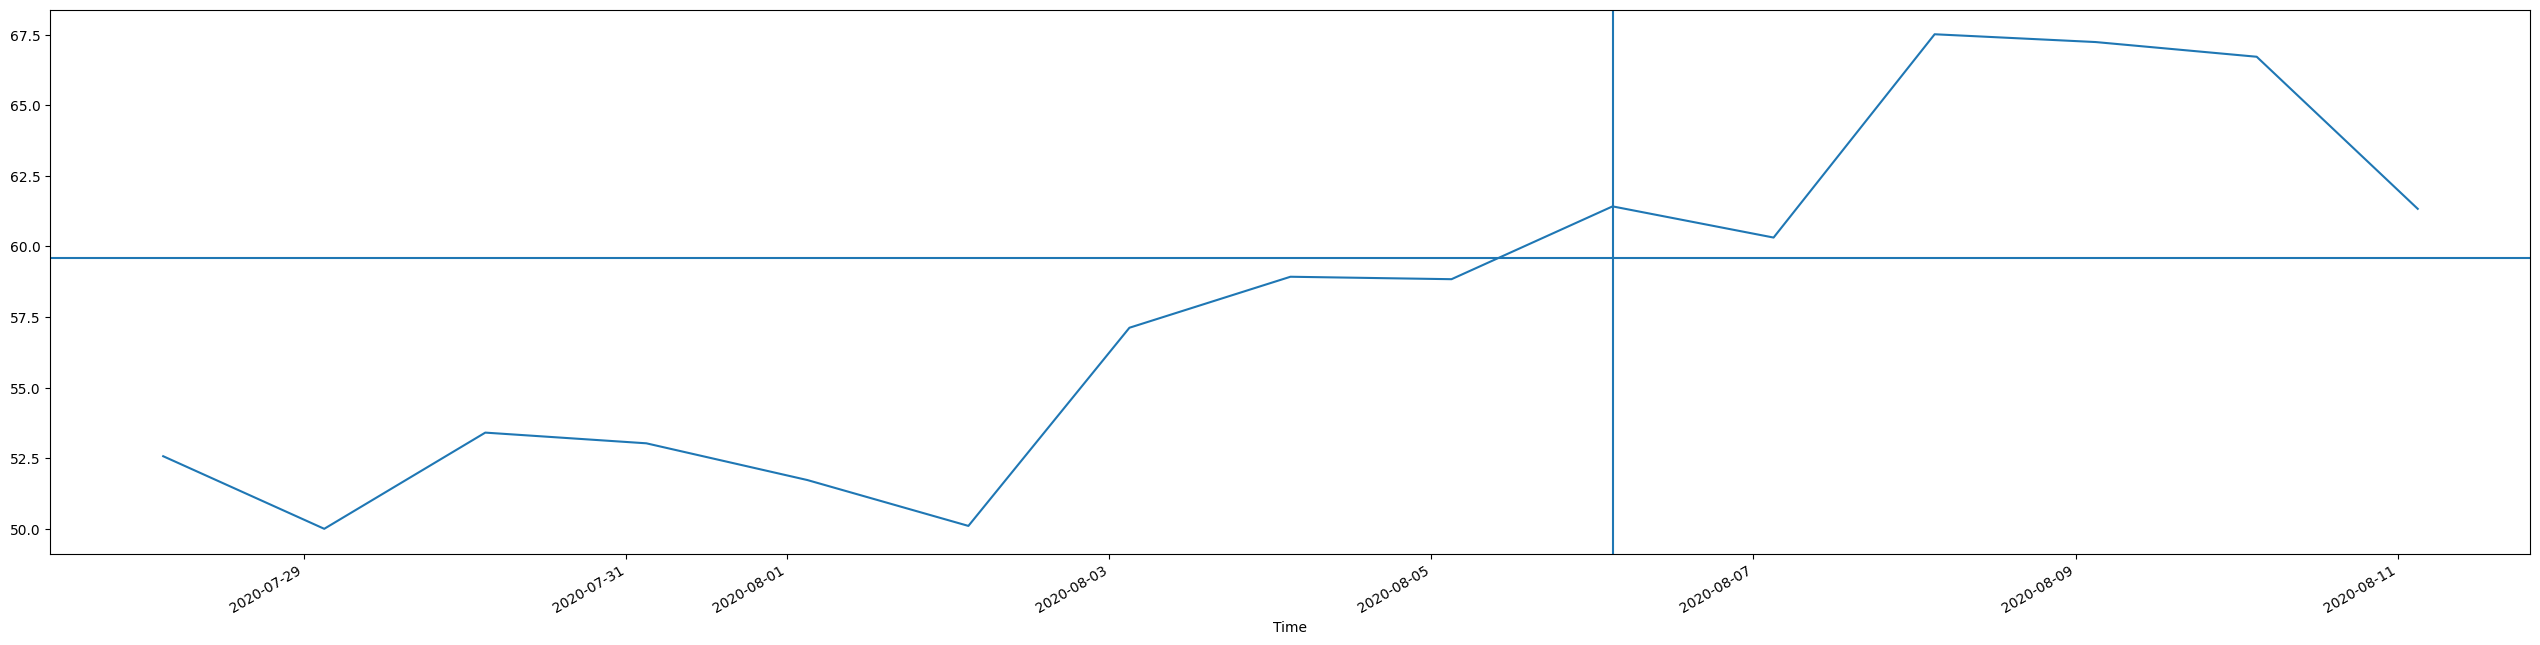

In [146]:
import matplotlib.pyplot as plt

roll_window = 20

res = y_test.to_frame("test")
res['predict'] = predict
res['symbol'] = data_set.loc[res.index, "symbol"]
res['before_pump_date'] = data_set.loc[res.index, "before_pump_date"]
res['data_type'] = data_set.loc[res.index, "data_type"]

for ind, row in res[(res["test"] != res['predict']) & (res["test"] == 0)].sample(2).iterrows():
    
    sample = results[results["Symbol"] == row['symbol']]

    sample.loc[:, ["High", "Low", "Close", "Open"]] = sample.loc[:, ["High", "Low", "Close", "Open"]].apply(normalize_prices)
    sample.loc[:, "cum_prod"] = sample["Close"].pct_change().add(1).rolling(window=roll_window).apply(np.prod).subtract(1).multiply(100).values
    pump = sample.loc[:(row["before_pump_date"]) + pd.Timedelta(days=5)].iloc[-15:]
    pump['Close'].plot()
    plt.axvline(x=(row["before_pump_date"]))
    plt.axhline(y=(sample.loc[row["before_pump_date"], "Close"]*0.97))
    plt.show()
    

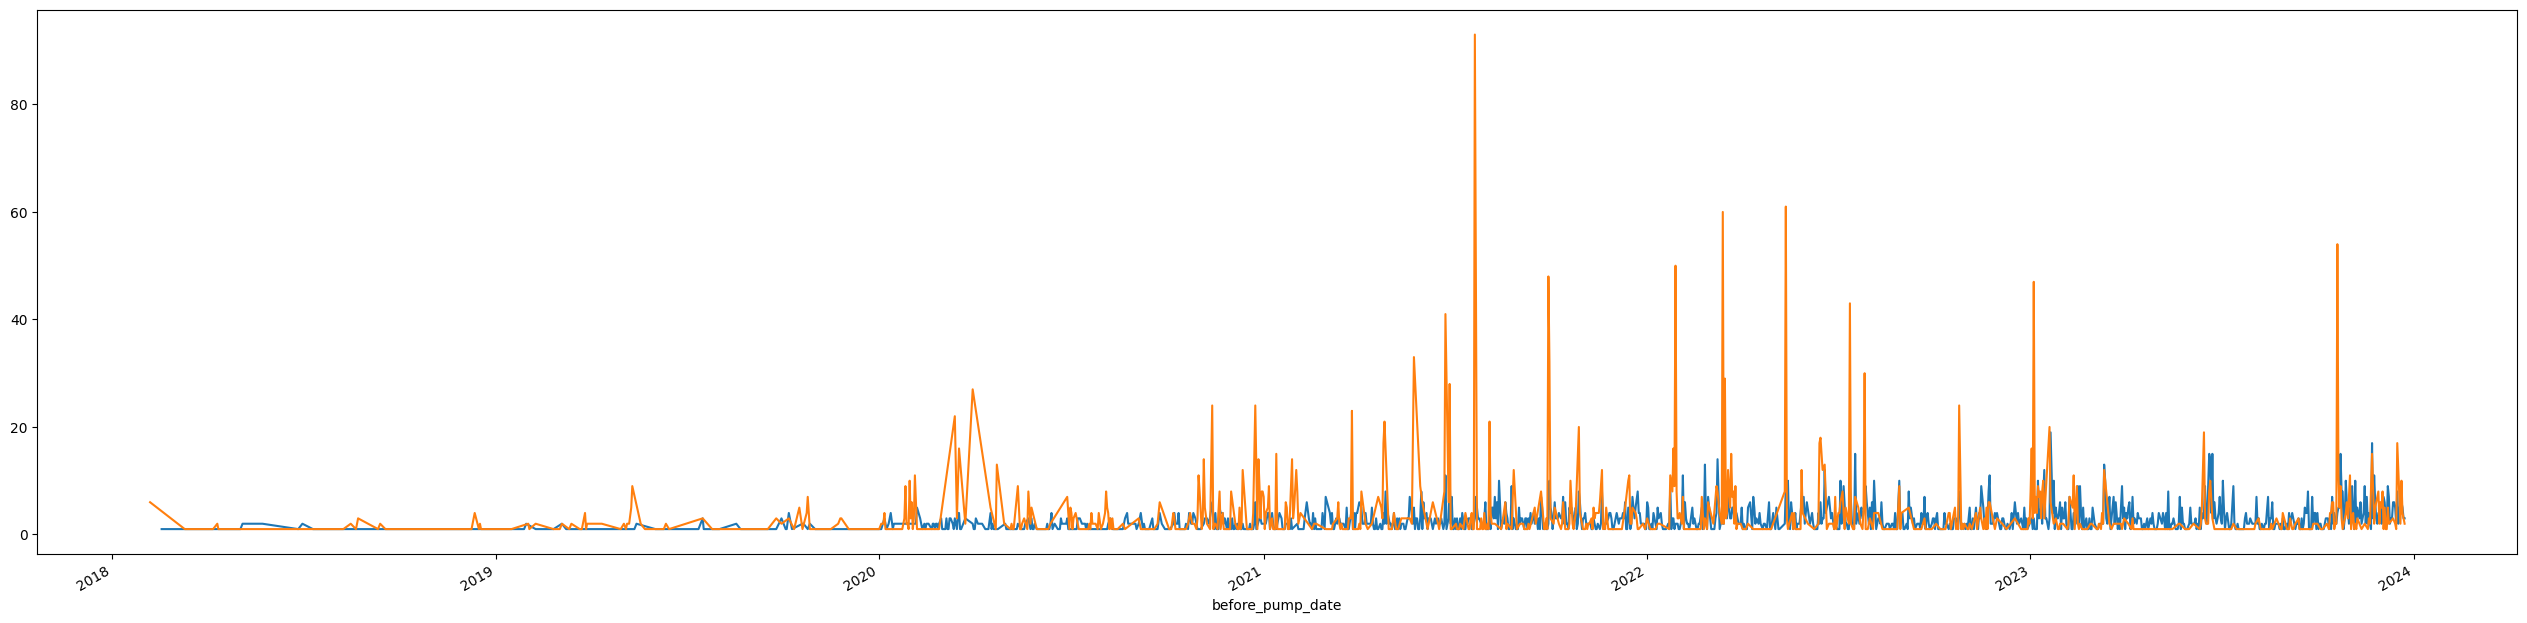

In [147]:
# Show days with a lot of pumps
plt.rcParams["figure.figsize"] = (32,8)
data_set[data_set['class'] == 0]["before_pump_date"].value_counts().sort_index(ascending=True).plot()
data_set[data_set['class'] == 1]["before_pump_date"].value_counts().sort_index(ascending=True).plot()
# .iloc[-50:-40]
plt.show()

In [143]:
# Which type of 0 class model difficult to define
df = res[(res["test"] != res['predict']) & (res["test"] == 0)]
df["data_type"].value_counts()

data_type
>5>0<15    369
>5<0       147
Name: count, dtype: int64

### Trash

In [603]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [41]:
from source.prices_source.binance_prices import get_candles_spot_binance
from source.utils import normalize_prices

from source.features.super_trend import calculate_supertrend
from source.features.macd import calculate_macd
from source.features.rsi import calculate_rsi
from source.features.obv import calculate_obv_to_volume_ratio
from source.features.bollinger_bands import distance_between_bb_bands
from source.features.chaikin_money_flow import calculate_cmf
from source.features.rate_of_change import calculate_price_rate_of_change, calculate_volume_rate_of_change
from source.features.volume_ratio import calculate_volume_ratio
from source.features.stoch_rsi import calculate_stoch_rsi
from source.features.linear_regression import calculate_trailing_linear_reg_params


features = {
    "calculate_supertrend": [["SuperTrend"], {"vol_func": "atr", "lookback": 20, "multiplier": 2.5}],
    "calculate_macd": [["MACD_Signal_Line", "MACD", "MACD_Bar_Charts"], {"short_period": 12, "long_period": 26, "smoothing_period": 9}],
    "calculate_rsi": [["RSI"], {"period": 20, "ema": True}],
    "calculate_obv_to_volume_ratio": [["OBV_Volume_Ratio"], {}],
    "distance_between_bb_bands": [["Upper_distance", "Lower_distance"], {"period": 20, "multiplier": 2.5, "ema": 2.5, "normalize": True}],
    "calculate_cmf": [["CMF"], {"period": 20}],
    "calculate_price_rate_of_change": [["Price_ROC"], {}],
    "calculate_volume_rate_of_change": [["Volume_ROC"], {}],
    "calculate_volume_ratio": [["Volume_Ratio"], {"period": 20, "ema": True}],
    "calculate_stoch_rsi": [["Stoch_RSI_K", "Stoch_RSI_D"], {"rsi_period": 20, "k_period": 20, "smooth_k": 5, "smooth_k": 5, "ema": True}],
    "calculate_trailing_linear_reg_params": [["Reg_Coef", "RMSE"], {"period": 25, "col_name": "cum_prod"}]
}

feature_cols = sum(list(map(lambda x: x[0], features.values())), [])

strategy_params = {
    "last_features_window": 7,
    "time_between_pump": 30,
    "candles_for_lin_reg": 25,
    "roll_window": 10, # candles
    "min_yield": -20, # %
    "max_yield": 20,
    "first_yield": 3
}


data_set = pd.DataFrame({})

symbols = results["Symbol"].unique()

for symbol in tqdm(symbols):
    
    # try:
    sample = results[results["Symbol"] == symbol]

    sample.loc[:, ["High", "Low", "Close", "Open"]] = sample.loc[:, ["High", "Low", "Close", "Open"]].apply(normalize_prices)
    sample = sample.iloc[1:]

    if len(sample) < strategy_params["time_between_pump"]:
        continue


    sample.loc[:, "cum_prod"] = sample["Close"].pct_change().add(1).rolling(window=strategy_params["roll_window"]).apply(np.prod).subtract(1).multiply(100).fillna(0).values
    sample.loc[:, "yield_at_pump"] = sample["Close"].pct_change().multiply(100).shift(strategy_params["roll_window"])


    for feature, values in features.items():
        eval(feature)(sample, **values[1])
    
    feature_df = sample[feature_cols].bfill()
    
    # Main observations
    outliers_values = sample[(sample["cum_prod"] >= strategy_params["max_yield"]) & (sample["yield_at_pump"] >= strategy_params["first_yield"])]
    
    # For diluting data
    other_values_first = sample[(sample["cum_prod"] < strategy_params["max_yield"]) & (sample["cum_prod"] > 0) & (sample["yield_at_pump"] >= strategy_params["first_yield"])]
    other_values_second = sample[(sample["cum_prod"] < 0) & (sample["yield_at_pump"] >= strategy_params["first_yield"])]
    other_values_third = sample[(sample["yield_at_pump"] < strategy_params["first_yield"])]


    if outliers_values.empty:
        continue

    outliers_values.loc[:, "time_delta"] = outliers_values.reset_index().Time.diff().apply(lambda x: x.days).fillna(10e5).values
    outliers_values = outliers_values[outliers_values["time_delta"] >= strategy_params["time_between_pump"]]

    for date in outliers_values.index:
        pump_date = date - pd.Timedelta(days=strategy_params["roll_window"])
        observations = sample.loc[:date].iloc[-strategy_params["candles_for_lin_reg"]:]

        observations.loc[:, "cum_yield"] = normalize_prices(observations.loc[:, "Close"])

        summary_dct = {
            'symbol': symbol,
            'pump_date': pump_date,
            'data_type': ">5>15",
            'class': 1
        }
        
        last_features = feature_df.loc[:pump_date].iloc[-5:]
        for name, values in last_features.items():
            for i, value in enumerate(values):
                summary_dct[name + "_" + str(i)] = value

        summary = pd.DataFrame(summary_dct, index=[len(data_set) + 1])

        data_set = pd.concat([data_set, summary])
    
    for sample_numb, data_name, other_values in [[4, ">5>0<15", other_values_first], [2, ">5<0", other_values_second], [2, "<0", other_values_third]]:
        for date in other_values.sample(frac=1).head(sample_numb).index:
            pump_date = date - pd.Timedelta(days=strategy_params["roll_window"])
            observations = sample.loc[:date].iloc[-strategy_params["candles_for_lin_reg"]:]

            observations.loc[:, "cum_yield"] = normalize_prices(observations.loc[:, "Close"])

            summary_dct = {
                'symbol': symbol,
                'pump_date': pump_date,
                'data_type': data_name,
                'class': 0
            }

            last_features = feature_df.loc[:pump_date].iloc[-5:]
            for name, values in last_features.items():
                for i, value in enumerate(values):
                    summary_dct[name + "_" + str(i)] = value

            summary = pd.DataFrame(summary_dct, index=[len(data_set) + 1])

            data_set = pd.concat([data_set, summary])
    
    print(np.where(symbols == symbol)[0][0])
    # except:
    #     continue

  0%|          | 0/478 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
11
12
13
14
15
16
18
19
21
22
24
25
26
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
96
97
98
99
100
101
102
103
104
105
106
107
109
110
111
112
113
114
115
118
119
120
121
122
123
125
126
127
128
129
130
131
132
133
134
135
136
137
138
140
143
144
145
146
147
148
149
150
151
152
153
155
156
158
159
160
161
162
163
165
167
168
169
170
171
173
174
175
176
177
178
179
180
181
182
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
249
250
251
252
253
254
255
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
29

In [42]:
import xgboost as xgb

data_set = data_set.dropna()
data_set = data_set[np.all(data_set != np.inf, axis=1)]
feature_names = data_set.drop(["symbol", "pump_date", "class", "data_type"], axis=1).columns

X_train, X_test, y_train, y_test = train_test_split(data_set.loc[:, feature_names], data_set.loc[:, 'class'].astype('int'), 
                                                    test_size = 0.2, shuffle=True)



xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42) # squarederror

params = {
    "colsample_bytree": [0.7, 0.3],
    "gamma": [0, 0.5],
    "learning_rate": [0.1, 0.03, 0.3], # default 0.1 
    "max_depth": [2, 6], # default 3
    "n_estimators": [100, 300], # default 100
    "subsample": [0.6, 0.4]
}

kfold = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

model = GridSearchCV(xgb_model, 
                     param_grid=params,
                     cv=kfold,
                     verbose=1,
                     n_jobs=6)


model.fit(X_train, y_train)


predict = model.best_estimator_.predict(X_test)
# predict_proba = random_forest_model.best_estimator_.predict_proba(X_test)

# rate, _ = optimal_threshold(predict_proba[:, 1])

# print(rate)
print(classification_report(y_test, predict))
print("accuracy: ", accuracy_score(y_test, predict))
print(confusion_matrix(y_test, predict))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       659
           1       0.71      0.83      0.77       568

    accuracy                           0.76      1227
   macro avg       0.77      0.77      0.76      1227
weighted avg       0.77      0.76      0.76      1227

accuracy:  0.7636511817440913
[[464 195]
 [ 95 473]]


In [69]:
df["ema_no_adjust"] = df['Close'].ewm(span=5, adjust=False).mean().round(4)
df["ema_adjust"] = df['Close'].ewm(span=5, adjust=True).mean().round(4)
df["equal"] = df["ema_adjust"] == df["ema_no_adjust"]